# **Using XGBoost to classify the results of the 'Acoustic Extinguisher Fire Dataset'**

## **Let's import the core libraries**

In [1]:
! pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 1.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import skew

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

## **Now read data from excel spreadsheet**

In [3]:
df = pd.read_excel('../input/acoustic-extinguisher-fire-dataset/Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx')
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


## **Collect some information about our data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


In [5]:
df.isna().sum()

SIZE         0
FUEL         0
DISTANCE     0
DESIBEL      0
AIRFLOW      0
FREQUENCY    0
STATUS       0
dtype: int64

In [6]:
df.describe()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,190.000000,113.000000,17.000000,75.000000,1.000000


In [7]:
oe = OrdinalEncoder()
df['FUEL'] = oe.fit_transform(df[['FUEL']])

In [8]:
oe.categories_

[array(['gasoline', 'kerosene', 'lpg', 'thinner'], dtype=object)]

In [9]:
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,0.0,10,96,0.0,75,0
1,1,0.0,10,96,0.0,72,1
2,1,0.0,10,96,2.6,70,1
3,1,0.0,10,96,3.2,68,1
4,1,0.0,10,109,4.5,67,1


## **For a better understanding, let's build some graphs**

### **Let's look at the distribution of fuels on a pie chart**

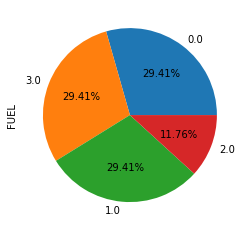

In [10]:
df['FUEL'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.show()

### **Let's look at the skewness of our data**

Col name: SIZE
Skewness: 0.2786998636581806


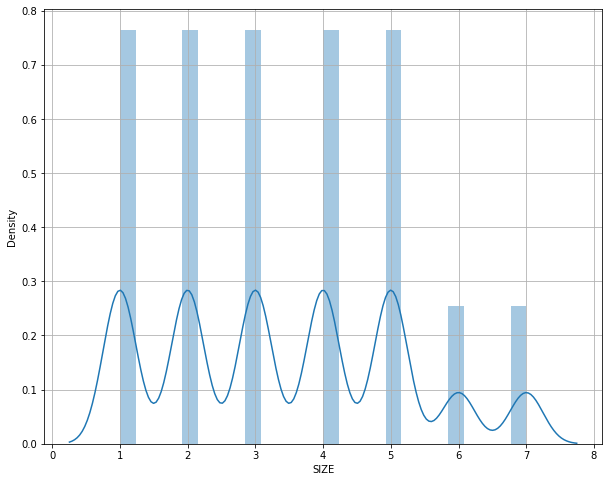

Col name: FUEL
Skewness: 0.20959140221588837


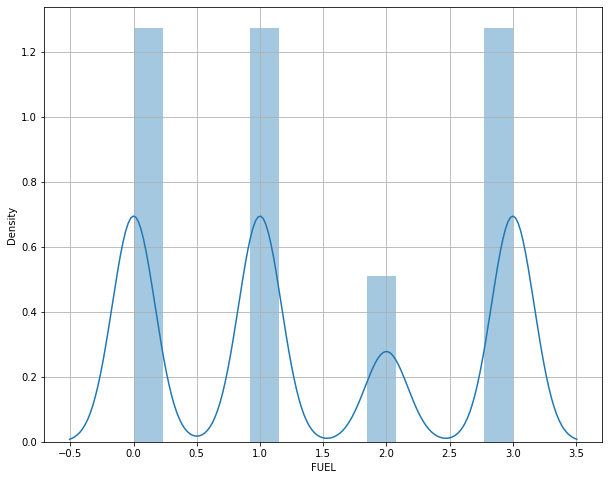

Col name: DISTANCE
Skewness: 0.0


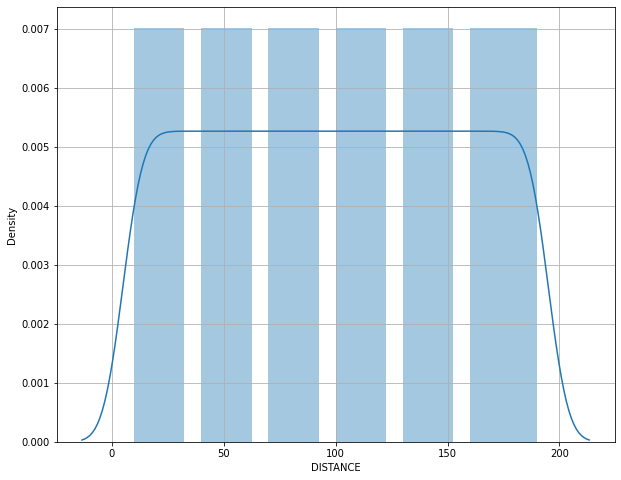

Col name: DESIBEL
Skewness: -0.17903195807888958


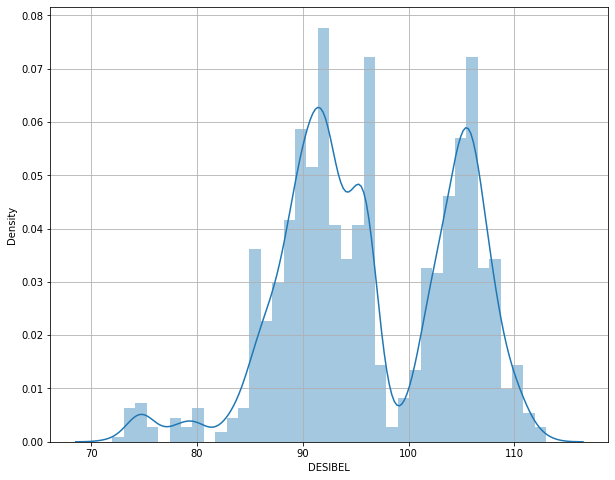

Col name: AIRFLOW
Skewness: 0.24434745944124117


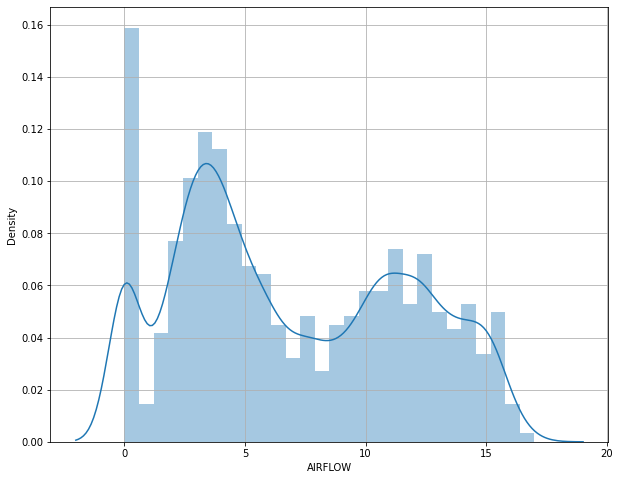

Col name: FREQUENCY
Skewness: 0.4348548916349596


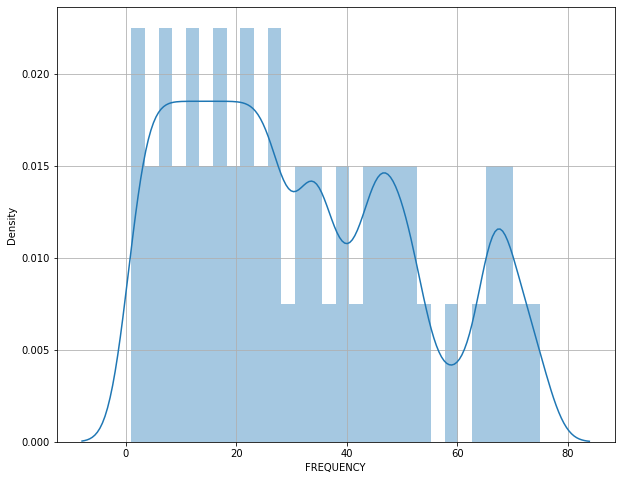

Col name: STATUS
Skewness: 0.008714679678955612


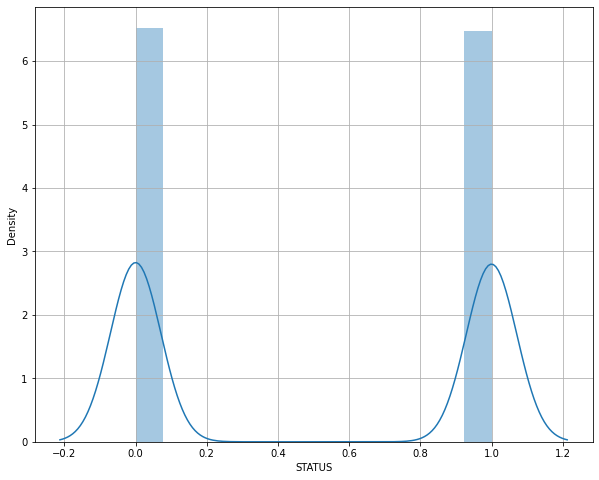

In [11]:
for col in df:
    print(f'Col name: {col}')
    print(f'Skewness: {skew(df[col])}')
    
    plt.figure(figsize=(10,8))
    sns.distplot(df[col])
    plt.grid(True)
    plt.show()

### **For a better understanding of the data correlation, we will build a heat map**

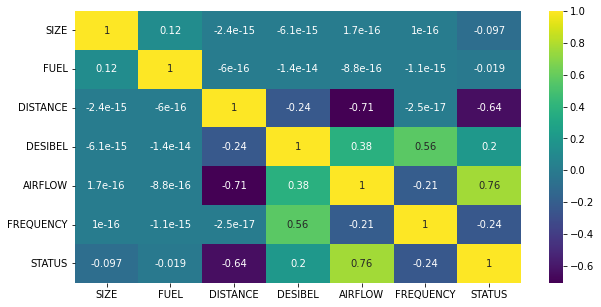

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.show()

### **Let's take a look at the uniqueness of values**

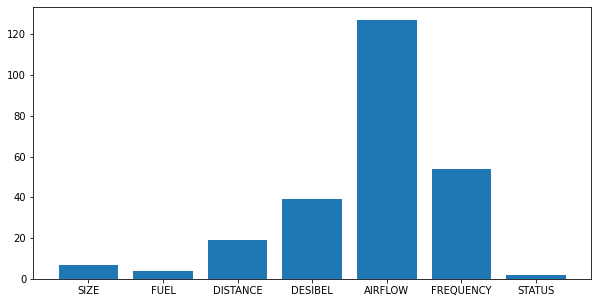

In [13]:
plt.figure(figsize=(10,5))
plt.bar(df.columns, df.nunique())
plt.show()

## **Preparing data for classification**

In [14]:
df.columns

Index(['SIZE', 'FUEL', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY',
       'STATUS'],
      dtype='object')

In [15]:
x = df.iloc[:,:-1]
x.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY
0,1,0.0,10,96,0.0,75
1,1,0.0,10,96,0.0,72
2,1,0.0,10,96,2.6,70
3,1,0.0,10,96,3.2,68
4,1,0.0,10,109,4.5,67


In [16]:
y = df.iloc[:, -1]
y.head()

0    0
1    1
2    1
3    1
4    1
Name: STATUS, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [18]:
st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)
X_test = st_sc.fit_transform(X_test)

## **Training and results of the XGBoost model**

In [19]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2614
           1       0.98      0.97      0.97      2619

    accuracy                           0.97      5233
   macro avg       0.97      0.97      0.97      5233
weighted avg       0.97      0.97      0.97      5233



In [20]:
print(f'Model actual accuracy: {accuracy_score(y_test, y_pred)}')

Model actual accuracy: 0.9740110835085037


In [21]:
confusion_matrix(y_test, y_pred)

array([[2566,   48],
       [  88, 2531]])